## Notes for estimatic yield curves
$$cd = p$$
$$d = c^{-1} p$$
$$d_i = e^{-r_i t_i} \rightarrow r_i = -\frac{ln(d_i)} { t_i} $$

In [1]:
#%load_ext autoreload
#%autoreload 1
import numpy as np
import scipy.linalg as la
from data.hullboot import data, cf

In [11]:
# load data
t = np.asarray(data["time_to_maturity"])
p = np.asarray(data["bond_price"])
cf = np.asarray(cf, dtype=float)

def add_g0_constraint(cf, p, t):
    n, m = cf.shape
    cf2, p2, t2 = np.zeros((n + 1, m + 1)), np.zeros(n + 1), np.zeros(m + 1)
    cf2[1:, 1:], p2[1:], t2[1:] = cf.copy(), p.copy(), t.copy()
    cf2[0, 0], p2[0]= 1, 1
    return cf2, p2, t2


In [12]:
def d2r(d, t):
    """discount->rate"""
    return -np.log(d) / t


def estimate_discount_curve(c, p):
    """Bootstrap fra cashflow matrix *c*, prices *p* and times *t*"""
    return la.solve(c, p)



In [13]:
discount_curve = estimate_discount_curve(cf, p)
curve = d2r(discount_curve, t)

curve_rounded = np.around(curve * 100, 3)
print(curve_rounded)  # passer med eksemplet i hull på side 107

[10.127 10.469 10.536 10.681 10.808]


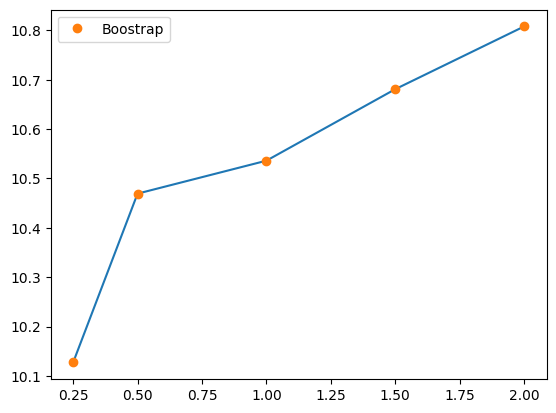

In [14]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

linear_interpol = interp1d(t, curve * 100)

xs = np.linspace(t.min(), t.max(), 100)
ys = linear_interpol(xs)

plt.plot(xs, ys)
plt.plot(t, curve * 100, "o", label="Boostrap")
plt.legend()


In [15]:
    # """Construct the smooth Moore-Penrose pseudoinverse discount curve g*(x)
    # Parameters
    # ----------
    #     c : (n, m)-shape float array
    #         cashflows
    #     p : (n,)-shape float array
    #         prices
    #     t : (m,)-shape float array
    #         cashflow "dates"
    # """

In [16]:
# Implementation of: "Exact Smooth Term-Strucure Estimation"
#                     Damir Filipovic and Sander Willems 2018

def phi(tau, x):
    y = min(tau, x)
    return 1 - y**3 / 6 + x * tau * (2 + y) / 2


def a_matrix(ts):
    n = len(ts)
    a = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            a[i, j] = phi(ts[i], ts[j])
    return a


def z_vector(a, c, p):
    return c.T @ la.solve(c @ a @ c.T, p)


def make_g_star(c, p, t):
    c, p, t = add_g0_constraint(c, p, t)
    z = z_vector(a_matrix(t), c, p)

    def g_star(x: float) -> float:
        return np.dot(z, [phi(tau=xi, x=x) for xi in t])

    return g_star


In [17]:
g_star = make_g_star(cf, p, t)

# esitmer kurven på en række tidspunkter
xs2 = np.linspace(0.25, 2.0, 100)
gs = [g_star(x) for x in xs2]
curve2 = d2r(gs, xs2)


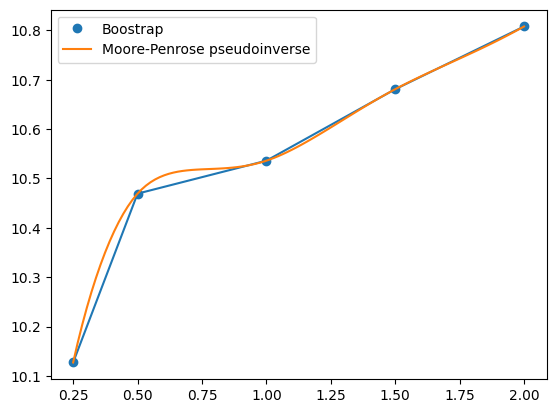

In [18]:

# plot kurverne
plt.plot(xs, ys)  # interpolated bootstrap
plt.plot(t, curve * 100, 'o', label='Boostrap', c='C0')
plt.plot(xs2, curve2 * 100, label='Moore-Penrose pseudoinverse')
plt.legend()